# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">2. Preprocessing & Cleaning</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |

---

### **2. Preprocessing & Cleaning Notebook**
**Description:**
This notebook processes the dataset from the Imports & Data Exploration notebook, addressing inconsistencies, handling missing values, and preparing the dataset for feature engineering. Key steps include:
- **Data Splitting:** Divide the dataset into training, validation, and test sets.
- **Outlier Removal:** Identify and handle extreme values systematically to improve data consistency.
- **Handling Missing Values:** Impute missing values based on conditional means, modes, or specific handling strategies for different features.
- **Output:** Save the **preprocessed dataset** in a structured format (CSV) for feature engineering.

This notebook ensures that the data is clean, consistent, and ready for further feature engineering.

---

<a id = "toc"></a>

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Import the Datasets](#chapter2)       
* [3. Train Test Split](#chapter3)
* [4. Preprocessing the Data](#chapter4)
    * [4.1. Outliers](#section_4_1) 
    * [4.2. Missing Values](#section_4_2) 
        * [4.2.1. Handling High Zero Columns](#sub_section_4_2_1)
        * [4.2.2. Handling Missing Values in IME-4 Count](#sub_section_4_2_2)
        * [4.2.3. Handling Missing Values in C-3 Date, C-2 Date, and First Hearing Date](#sub_section_4_2_3)
        * [4.2.4. Handling Missing Values in Industry Code](#sub_section_4_2_4) 
        * [4.2.5. Handling Missing Values in Average Weekly Wage](#sub_section_4_2_5)
        * [4.2.6. Handling Missing Values in Zip Code](#sub_section_4_2_6)
        * [4.2.7. Handling Missing Values in Birth Year](#sub_section_4_2_7)
        * [4.2.8. Handling Missing Values in Injury Codes](#sub_section_4_2_8) 
        * [4.2.9. Remaining Missing Values](#sub_section_4_2_9) 
* [5. Save Dataset for Feature Engineering](#chapter5)


# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

[Back to ToC](#toc)<br>

In this section we will imported the needed libraries for this notebook.

In [27]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile
import re
import os


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')

#Import functions from utils
from utils import analyze_numerical_outliers

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

Now, we will load the dataset prepared in **Notebook 1: Imports & Data Exploration**, where we addressed key inconsistencies such as invalid codes, and other data quality issues. This cleaned dataset serves as the foundation for the preprocessing steps in this notebook.

In [28]:
df_train = pd.read_csv(r'../processed_datasets/cleaned_train_dataset.csv', index_col='Claim Identifier')
df_test = pd.read_csv(r'../processed_datasets/cleaned_test_dataset.csv',index_col='Claim Identifier')

In [29]:
df_train.isnull().sum() 

Accident Date                   3687
Age at Injury                  59993
Assembly Date                   1407
Attorney/Representative            0
Average Weekly Wage            28651
Birth Year                     55033
C-2 Date                       15540
C-3 Date                      386781
Carrier Name                       0
Carrier Type                       0
Claim Injury Type                  0
County of Injury                   0
COVID-19 Indicator                 0
District Name                      0
First Hearing Date            423302
Gender                             0
IME-4 Count                   441221
Industry Code                   9956
Medical Fee Region                 0
WCIO Cause of Injury Code      15638
WCIO Nature of Injury Code     15655
WCIO Part Of Body Code         17080
Zip Code                       28983
Agreement Reached                  0
Number of Dependents               0
dtype: int64

# 3. Train Test Split <a class="anchor" id="chapter3"></a>
[Back to ToC](#toc)<br>

Splitting the dataset into training and test sets is a crucial step in building a machine learning model. In this project, we perform the train-test split after correcting inconsistencies but before data preprocessing, such as handling missing values, outlier treatment, and feature scaling. This sequence helps in maintaining the integrity of our data and ensures that the model is trained and evaluated fairly.

The train-test split is performed after fixing inconsistencies but before preprocessing to ensure that we do not inadvertently introduce information from the test set into the training set. This allows us to maintain the integrity of our model evaluation and helps ensure that the results obtained during model evaluation are unbiased and reflect the model’s performance on truly unseen data.

In [30]:
X= df_train.drop('Claim Injury Type',axis=1)
y= df_train['Claim Injury Type']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, 
                                                  random_state = 42, 
                                                  stratify = y, 
                                                  shuffle = True)

# 4. Preprocessing the Dataset ⚒️ <a class="anchor" id="chapter4"></a>
[Back to ToC](#toc)<br>


In this chapter, we will perform the basic steps to get to know our dataset.


## 4.1. Outliers <a class="anchor" id="section_4_1"></a>
[Back to 4. Preprocessing the Dataset](#chapter4)<br>


The columns below are those that may have outliers in our dataset:

- **Age at Injury** – The age of the person at the time of the accident.
- **Average Weekly Wage** – Average weekly wage.
- **Birth Year** – Year of the birth.
- **IME-4 Count** – Number of IME-4 forms received per claim.

In [31]:
X_train.columns

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Agreement Reached', 'Number of Dependents'],
      dtype='object')

In [32]:
numerical_vars = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count']

In [33]:
# Call the function to Analyze numerical variables for potential outliers using IQR present in utils
numerical_outliers_summary = analyze_numerical_outliers(X_train, numerical_vars)

# Display the summary
print("Number of potential outliers in numerical variables:")
for column, count in numerical_outliers_summary.items():
    print(f"{column}: {count} outliers")

Number of potential outliers in numerical variables:
Age at Injury: 0 outliers
Average Weekly Wage: 17740 outliers
Birth Year: 0 outliers
IME-4 Count: 5756 outliers


Lets use some graphs to check the values in a boxplot

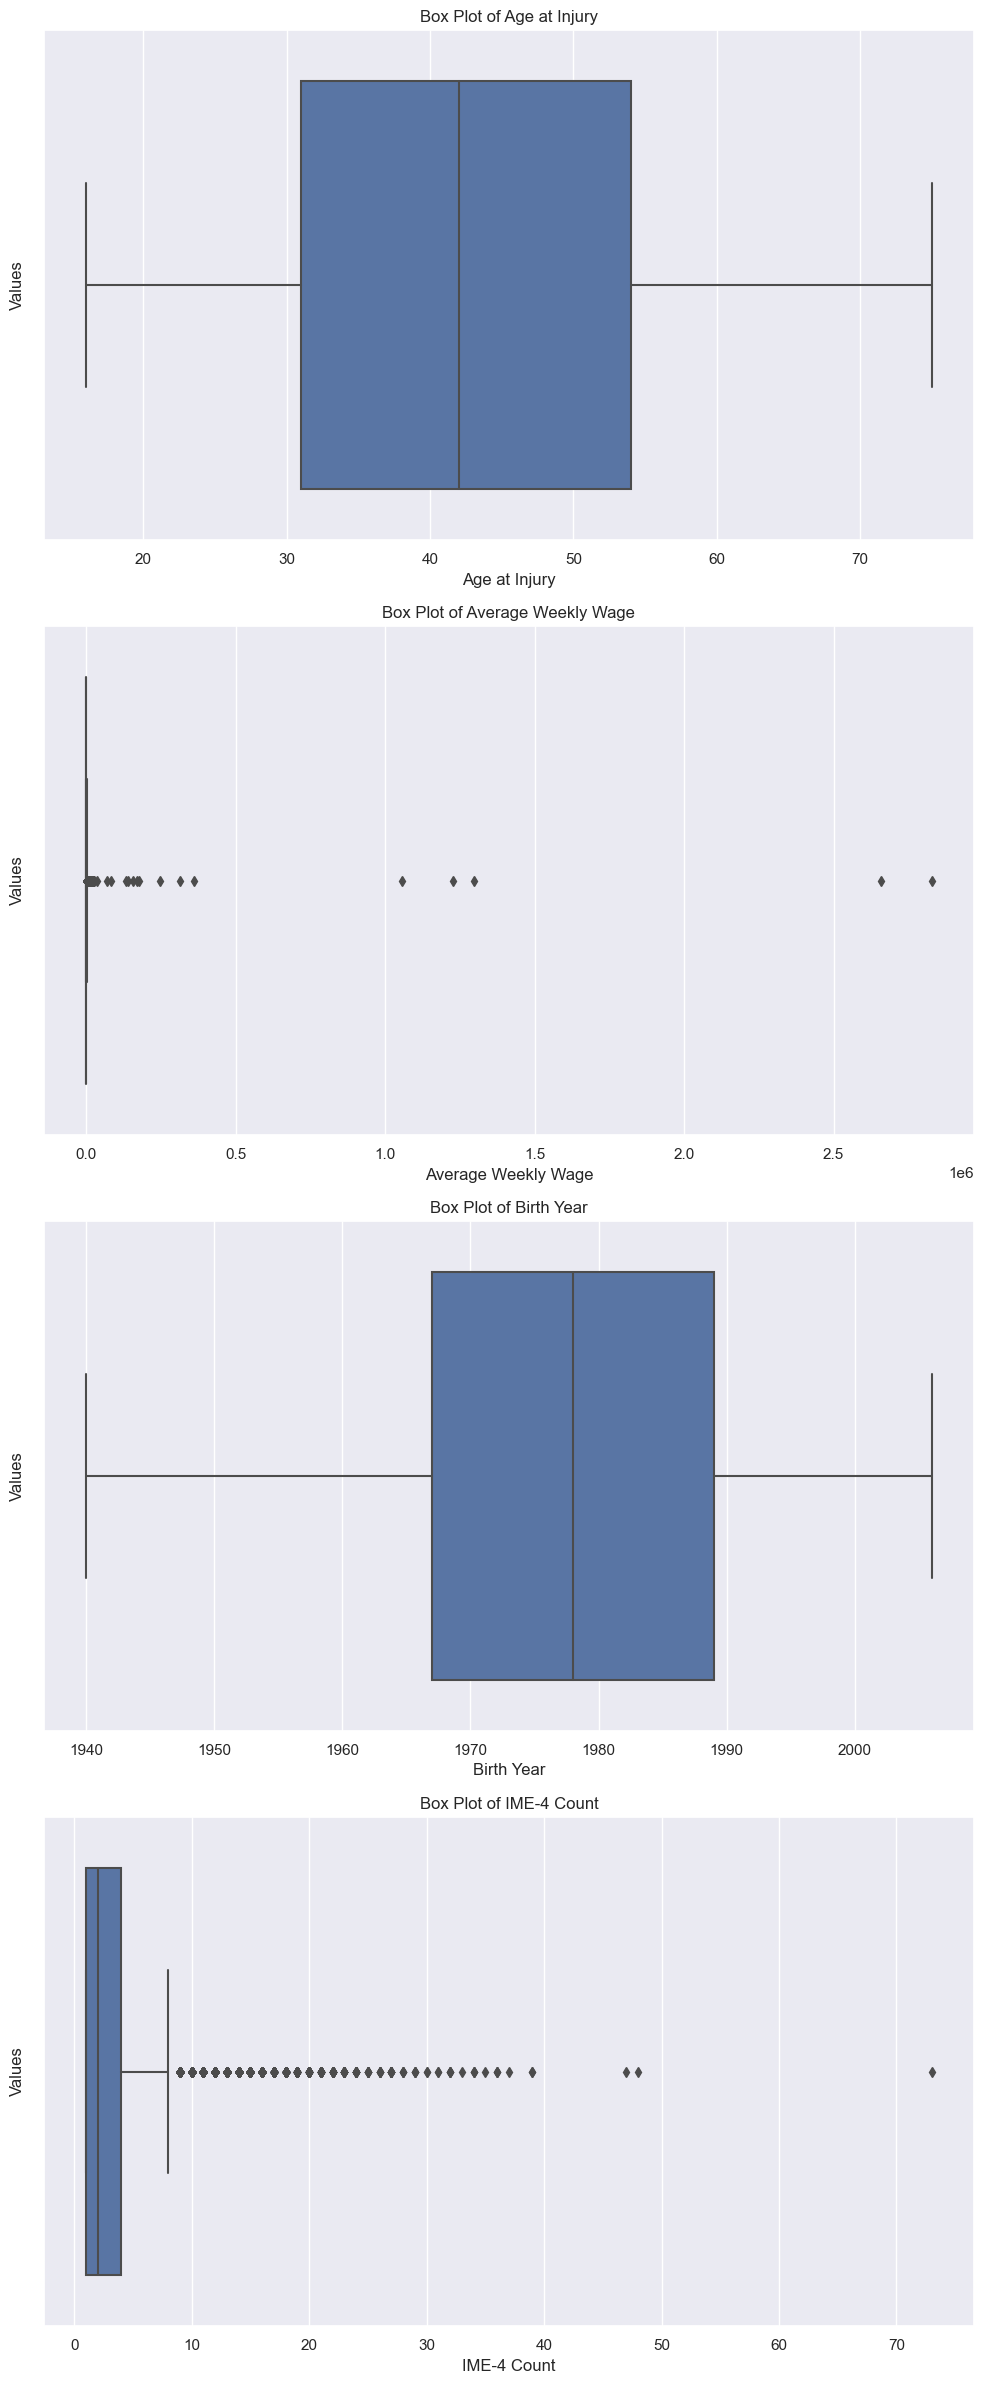

In [34]:
plt.figure(figsize=(10, 6 * len(numerical_vars)))

# Loop through each numeric column and plot a separate box plot
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(len(numerical_vars), 1, i)
    sns.boxplot(x=X_train[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Average Weekly Wage** <br>
Based on the analysis of the numerical variables in the dataset, most variables exhibit consistent distributions with few extreme outliers. However, the Average Weekly Wage variable presents significant skewness caused by both zero values and extreme values exceeding 1.0×10^6. To address this, we exclude both zeros and extreme values for a clearer analysis of its central distribution.

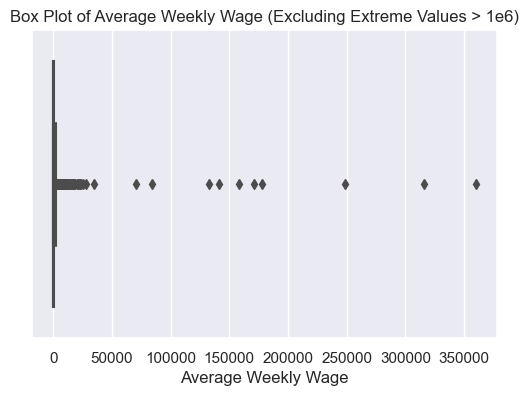

In [35]:
# Filter out extreme values
filtered_avg_weekly_wage = X_train['Average Weekly Wage'][X_train['Average Weekly Wage'] <= 1e6]

# Plot the boxplot for Average Weekly Wage excluding extreme values
plt.figure(figsize=(6, 4))
sns.boxplot(x=filtered_avg_weekly_wage)
plt.title("Box Plot of Average Weekly Wage (Excluding Extreme Values > 1e6)")
plt.xlabel("Average Weekly Wage")
plt.show()

Based on the analysis of the Average Weekly Wage variable, we observe that even after excluding extreme values beyond 1.0×10^6, there remain unusually high entries above 50,000. These values are inconsistent with realistic weekly wages, as they far exceed typical compensation ranges. To further refine our analysis, we will exclude all entries above 50,000 and analyze the resulting distribution.

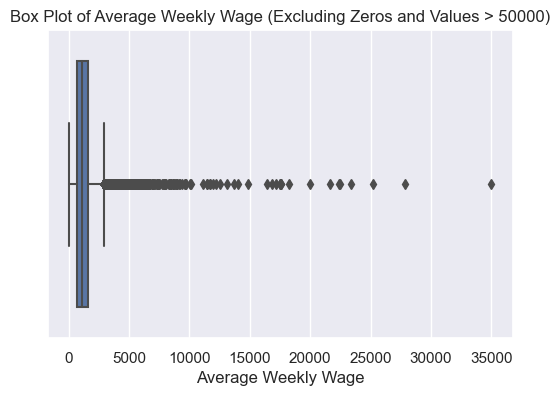

In [36]:
# Filter out zeros and values above 50000
filtered_avg_weekly_wage = X_train['Average Weekly Wage'][
    (X_train['Average Weekly Wage'] > 0) & (X_train['Average Weekly Wage'] <= 50000)
]

# Plot the refined boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=filtered_avg_weekly_wage)
plt.title("Box Plot of Average Weekly Wage (Excluding Zeros and Values > 50000)")
plt.xlabel("Average Weekly Wage")
plt.show()

Upon analyzing the **Average Weekly Wage** variable and progressively refining the thresholds, it becomes evident that values above **10,000** likely represent outliers or unrealistic entries. The boxplot, which excludes values greater than **50,000**, highlights a concentration of reasonable wages below this level, with a few extreme values still visible.

Given the nature of weekly wages, a threshold of 10,000 strikes a balance between excluding extreme, unlikely values while retaining as much valid data as possible. This adjustment ensures the dataset remains representative without being skewed by unrealistic entries.

In [37]:
# Define the threshold for outliers
outlier_threshold = 10000

# Identify rows with 'Average Weekly Wage' above the threshold
outlier_rows = X_train[X_train['Average Weekly Wage'] > outlier_threshold]

# Calculate the percentage of rows identified as outliers
num_outliers = outlier_rows.shape[0]
total_rows = X_train.shape[0]
outlier_percentage = (num_outliers / total_rows) * 100

# Print results
print(f"Number of rows with 'Average Weekly Wage' > {outlier_threshold}: {num_outliers}")
print(f"Percentage of total rows: {outlier_percentage:.4f}%")

Number of rows with 'Average Weekly Wage' > 10000: 45
Percentage of total rows: 0.0098%


Upon analysis, 45 rows (representing 0.0098% of the total dataset) have Average Weekly Wage values exceeding 10,000, which appear to be outliers. Given the nature of weekly wages, these values are likely unrealistic and could skew the distribution or negatively impact model performance.

To address this issue, we will apply a **Winsorization** approach. Winsorizing involves capping extreme values at a specified threshold—in this case, 10,000—to bring them within a more acceptable range. This method preserves the affected rows without removing data while reducing the influence of outliers.

In [38]:
# Cap the 'Average Weekly Wage' values at 10,000 (Winsorization)
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(upper=10000)
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].clip(upper=10000)
df_test['Average Weekly Wage'] = df_test['Average Weekly Wage'].clip(upper=10000)

# Verify the changes
print("Number of rows with 'Average Weekly Wage' > 10000 after capping:",
      (X_train['Average Weekly Wage'] > 10000).sum())

Number of rows with 'Average Weekly Wage' > 10000 after capping: 0


Final Boxplot Distribution:

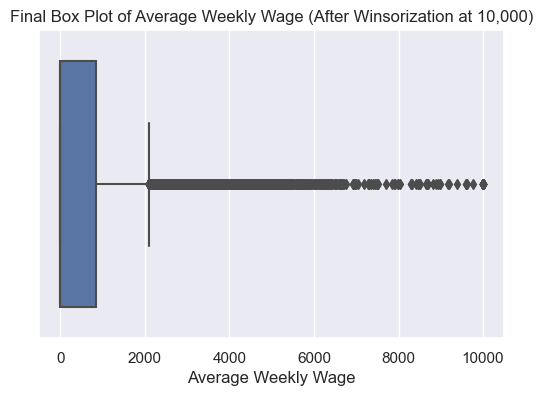

In [39]:
# Final boxplot after capping extreme values at 10,000
plt.figure(figsize=(6, 4))
sns.boxplot(x=X_train['Average Weekly Wage'])
plt.title("Final Box Plot of Average Weekly Wage (After Winsorization at 10,000)")
plt.xlabel("Average Weekly Wage")
plt.show()

**IME-4 Count** <br>
Another point of concern is the IME-4 Count therefore, we will adopt an approach very similar to the previous one.

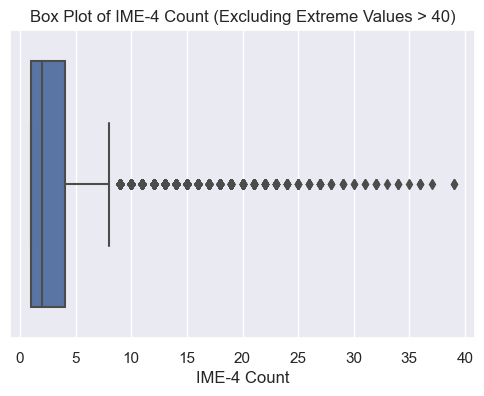

In [40]:
# Filter out extreme values
filtered_IME = X_train['IME-4 Count'][X_train['IME-4 Count'] <= 40]

# Plot the boxplot for IME-4 Count excluding extreme values
plt.figure(figsize=(6, 4))
sns.boxplot(x=filtered_IME)
plt.title("Box Plot of IME-4 Count (Excluding Extreme Values > 40)")
plt.xlabel("IME-4 Count")
plt.show()

Based on the box plot analysis of the **IME-4 Count** variable, we observed that values beyond **25** appear to be outliers. These extreme values deviate significantly from the majority of the data, indicating they may not be representative of typical observations.

To address this, we applied **winsorizing** at the threshold of 25. Winsorizing reduces the impact of outliers by capping values above this threshold to the maximum acceptable limit, ensuring the data remains robust for modeling while preserving its overall distribution.

In [41]:
# Define the threshold for outliers
outlier_threshold = 25

# Identify rows with 'IME-4 Count' above the threshold
outlier_rows = X_train[X_train['IME-4 Count'] > outlier_threshold]

# Calculate the percentage of rows identified as outliers
num_outliers = outlier_rows.shape[0]
total_rows = X_train.shape[0]
outlier_percentage = (num_outliers / total_rows) * 100

# Print results
print(f"Number of rows with 'IME-4 Count' > {outlier_threshold}: {num_outliers}")
print(f"Percentage of total rows: {outlier_percentage:.4f}%")

Number of rows with 'IME-4 Count' > 25: 47
Percentage of total rows: 0.0102%


In [42]:
# Cap the 'IME-4 Count' values at 25 (Winsorization)
X_train['IME-4 Count'] = X_train['IME-4 Count'].clip(upper=25)
X_val['IME-4 Count'] = X_val['IME-4 Count'].clip(upper=25)
df_test['IME-4 Count'] = df_test['IME-4 Count'].clip(upper=25)

# Verify the changes
print("Number of rows with 'IME-4 Count' > 25 after capping:",
      (X_train['IME-4 Count'] > 25).sum())

Number of rows with 'IME-4 Count' > 25 after capping: 0


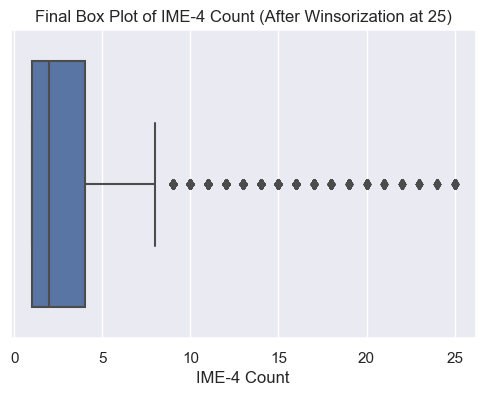

In [43]:
# Final boxplot after capping extreme values at 25
plt.figure(figsize=(6, 4))
sns.boxplot(x=X_train['IME-4 Count'])
plt.title("Final Box Plot of IME-4 Count (After Winsorization at 25)")
plt.xlabel("IME-4 Count")
plt.show()

## 4.2. Missing Values <a class="anchor" id="section_4_2"></a>
[Back to 4. Preprocessing the Dataset](#chapter4)<br>

### Handling High Zero Columns 
In some cases, missing values might have been incorrectly represented as zeros, which can lead to inaccurate analysis and modeling. To address this, we will use the `.eq(0)` method to identify columns where zero values may not be appropriate and investigate their validity. This step ensures that we accurately distinguish between true zeros and potential missing or invalid data points, setting the foundation for proper handling of missing values in the dataset. In this section, we identify columns with a high number of zero values to ensure that they are not incorrectly used as placeholders for missing values. This analysis allows us to differentiate between valid zero entries and potential data inconsistencies that need to be addressed during preprocessing.


In [44]:
# Calculate the percentage of zeros for each column
zero_percentage = X_train.eq(0).mean()

# Filter columns that have more than the threshold of zero values
high_zero_columns = zero_percentage[zero_percentage > 0.0]

# Display the columns with their zero percentage
print(high_zero_columns*100)

Attorney/Representative    68.329708
Average Weekly Wage        58.396103
COVID-19 Indicator         95.157213
Zip Code                    0.001307
Agreement Reached          95.353197
Number of Dependents       14.242660
dtype: float64


**Interpretation:**
- **Attorney/Representative**: 66.10% zeros. This is expected as it likely indicates cases without attorney representation.
- **Average Weekly Wage**: 56.48% zeros. This is concerning because every employee in the dataset should have a weekly wage. Zeros in this column likely represent missing or incorrectly recorded values.
- **COVID-19 Indicator**: 92.05% zeros. As a binary column, zero likely indicates claims unrelated to COVID-19, which is valid.
- **Agreement Reached**: 92.23% zeros. Similarly, this binary column likely indicates cases where no agreement was reached, which is valid.
- **Number of Dependents**: 14.24% zeros. Which represets those who does not have a dependents.
- **Zip Code**: 0.0011% zeros. Although the proportion is small, it is highly unusual for a zip code to be zero. This indicates missing or incorrectly recorded values in this column.

The remaining columns with a high proportion of zeros (Attorney/Representative, COVID-19 Indicator, and Agreement Reached) are binary features where zero values are expected and valid, so no changes will be made to these columns.

In [45]:
# Replace zeros in 'Average Weekly Wage' with NaN in the train, validation, and test sets
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].replace(0, np.nan)
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].replace(0, np.nan)
df_test['Average Weekly Wage'] = df_test['Average Weekly Wage'].replace(0, np.nan)

# Replace zeros in 'Zip Code' with NaN in the train, validation, and test sets
X_train['Zip Code'] = X_train['Zip Code'].replace(0, np.nan)
X_val['Zip Code'] = X_val['Zip Code'].replace(0, np.nan)
df_test['Zip Code'] = df_test['Zip Code'].replace(0, np.nan)

### Identifying Remaining Missing Values

After treating zeros as missing values in the **Average Weekly Wage** and **Zip Code** column, we will now examine the dataset for any remaining `NaN` values. This step ensures that all missing data points are identified, enabling us to address them systematically.

The table below displays the count of missing values (NaN) for each column in the dataset. Some columns, such as **First Hearing Date** and **IME-4 Count**, contain a significant number of missing values, which may require further investigation and treatment.

In [46]:
# Display count of NaN values for each column in the training dataset
X_train.isnull().sum()

Accident Date                   2949
Age at Injury                  48011
Assembly Date                   1153
Attorney/Representative            0
Average Weekly Wage           291126
Birth Year                     44031
C-2 Date                       12393
C-3 Date                      309600
Carrier Name                       0
Carrier Type                       0
County of Injury                   0
COVID-19 Indicator                 0
District Name                      0
First Hearing Date            338707
Gender                             0
IME-4 Count                   353017
Industry Code                   7943
Medical Fee Region                 0
WCIO Cause of Injury Code      12448
WCIO Nature of Injury Code     12463
WCIO Part Of Body Code         13564
Zip Code                       23137
Agreement Reached                  0
Number of Dependents               0
dtype: int64

In [47]:
# Calculate the percentage of missing values for each column
missing_percentage = X_train.isnull().mean()

# Filter columns that have more than the threshold of missing values
high_missing_columns = missing_percentage[missing_percentage > 0.0]

# Display the columns with their missing percentage
print(high_missing_columns*100)

Accident Date                  0.642177
Age at Injury                 10.454925
Assembly Date                  0.251078
Average Weekly Wage           63.395896
Birth Year                     9.588236
C-2 Date                       2.698712
C-3 Date                      67.418813
First Hearing Date            73.757183
IME-4 Count                   76.873344
Industry Code                  1.729676
WCIO Cause of Injury Code      2.710689
WCIO Nature of Injury Code     2.713956
WCIO Part Of Body Code         2.953711
Zip Code                       5.038337
dtype: float64


Using a threshold of 20%, we identified columns with a high percentage of missing values. Columns such as **First Hearing Date** and **IME-4 Count** have more than 70% missing data, which makes them candidates for potential feature engineering or alternative handling.

In particular:
- **First Hearing Date**: Given its high missing rate, this feature could potentially be transformed into a binary indicator, where 0 indicates missing and 1 indicates available data. This approach allows us to retain any signal that might be present in the presence or absence of this information.

Let's explore more about the rest of missing values.

### 4.2.1. Handling Missing Values in `IME-4 Count` <a class="anchor" id="sub_section_4_2_1"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


The `IME-4 Count` feature represents the number of independent medical audit examinations. A missing value (`NaN`) in this column likely indicates that no audits were conducted for a specific case. Therefore, we have decided to replace all `NaN` values with 0 to indicate that there was no audit.



In [48]:
# Display unique values in 'IME-4 Count' to understand the range
X_train['IME-4 Count'].unique()

array([ 4., nan,  1.,  8., 11.,  2.,  5.,  7.,  3., 14., 13.,  6., 12.,
       10.,  9., 15., 25., 16., 18., 17., 19., 20., 21., 22., 23., 24.])

As IME-4 represents the number of independent medical audicts examination we decided to convert nan to 0 meaning that there wasn't any.

In [49]:
# Replace NaN values in 'IME-4 Count' with 0 in the training, validation, and test sets
X_train['IME-4 Count'].fillna(0, inplace=True)
X_val['IME-4 Count'].fillna(0, inplace=True)
df_test['IME-4 Count'].fillna(0, inplace=True)

# Confirm replacement by displaying unique values again
X_train['IME-4 Count'].unique()

array([ 4.,  0.,  1.,  8., 11.,  2.,  5.,  7.,  3., 14., 13.,  6., 12.,
       10.,  9., 15., 25., 16., 18., 17., 19., 20., 21., 22., 23., 24.])

### 4.2.2. Handling Missing Values in `C-3 Date`, `C-2 Date`, and `First Hearing Date` <a class="anchor" id="sub_section_4_2_2"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


After reviewing the documentation from data.gov.ny, it was discovered that missing values (NaN) in the C-3 Date, C-2 Date, and First Hearing Date columns have a specific meaning: "blanks indicate no form received."

Given this clarification, we will no longer treat these as missing values. Instead:

Missing values (NaN) will be replaced with 0 to indicate "No form received."
This adjustment ensures that the data accurately reflects the provided context and avoids misinterpretation of missing values as a lack of data.


In [50]:
# Replace NaN values in specified columns with 0 to indicate "No form received"
columns_to_update = ['C-3 Date', 'C-2 Date', 'First Hearing Date']
X_train[columns_to_update] = X_train[columns_to_update].fillna(0)
X_val[columns_to_update] = X_val[columns_to_update].fillna(0)
df_test[columns_to_update] = df_test[columns_to_update].fillna(0)

### 4.2.3. Handling Missing Values in `Industry Code` <a class="anchor" id="sub_section_4_2_3"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


To address the missing values in the Industry Code feature, we utilize the KNN Imputation method. This method ensures that the imputed values are consistent with the dataset's underlying patterns by leveraging the relationships between features.

In [51]:
X_train['Industry Code'].isna().sum()

7943

### for now let just use the mode to fill the missing values.

In [52]:
# Calculate the mode of the 'Industry Code' column in X_train
industry_code_mode = X_train['Industry Code'].mode()[0]

# Fill missing values in 'Industry Code' for X_train, X_val, and df_test
X_train['Industry Code'].fillna(industry_code_mode, inplace=True)
X_val['Industry Code'].fillna(industry_code_mode, inplace=True)
df_test['Industry Code'].fillna(industry_code_mode, inplace=True)

# Verify the changes
print("Missing values in 'Industry Code' after filling:")
print("X_train:", X_train['Industry Code'].isna().sum())
print("X_val:", X_val['Industry Code'].isna().sum())
print("df_test:", df_test['Industry Code'].isna().sum())


Missing values in 'Industry Code' after filling:
X_train: 0
X_val: 0
df_test: 0


In [53]:
# # Define the feature to impute and the predictors
#feature_to_impute = 'Industry Code'
#predictor_features = X_train.select_dtypes(include=['int64', 'float64']).columns.drop(['Agreement Reached','Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])

# drop all "code" variables (wcio, etc.) on the row above this one

# Ensure 'Industry Code' is part of the predictors
#if feature_to_impute not in predictor_features:
    #predictor_features = predictor_features.append(pd.Index([feature_to_impute]))

# # Scale numerical features for X_train
#scaler = StandardScaler()
#scaled_data_train = scaler.fit_transform(X_train[predictor_features])

# # Apply KNN Imputation for all numerical features in X_train
#knn_imputer = KNNImputer(n_neighbors=3)  # Adjust n_neighbors for speed/accuracy tradeoff
#imputed_data_train = knn_imputer.fit_transform(scaled_data_train)

# Reverse scaling for all numerical features
#X_train[predictor_features] = scaler.inverse_transform(imputed_data_train)

# Process X_val and df_test using the same scaler and KNN imputer
#scaled_data_val = scaler.transform(X_val[predictor_features])
#scaled_data_test = scaler.transform(df_test[predictor_features])

# Apply KNN Imputation for 'Industry Code' in X_val and df_test
#imputed_data_val = knn_imputer.transform(scaled_data_val)
#imputed_data_test = knn_imputer.transform(scaled_data_test)

# # Reverse scaling for all numerical features in X_val and df_test
#X_val[predictor_features] = scaler.inverse_transform(imputed_data_val)
#df_test[predictor_features] = scaler.inverse_transform(imputed_data_test)

# Verify that missing values in 'Industry Code' have been imputed
#print("Missing values in 'Industry Code' after imputation (X_train):", X_train[feature_to_impute].isna().sum())
#print("Missing values in 'Industry Code' after imputation (X_val):", X_val[feature_to_impute].isna().sum())
#print("Missing values in 'Industry Code' after imputation (df_test):", df_test[feature_to_impute].isna().sum())

Since the KNN Imputation process takes approximately 18 hours (~1050 minutes), we will save the X_train, X_val, and df_test datasets in a dedicated folder named "Data After Impute". This allows us to reuse the imputed datasets in the future without re-running the imputation process.

In [54]:
# # Create the directory if it doesn't already exist
os.makedirs("../Data After Impute", exist_ok=True)

# # Save the datasets as CSV files
X_train.to_csv(os.path.join("../Data After Impute", "X_train_imputed.csv"), index=True)
X_val.to_csv(os.path.join("../Data After Impute", "X_val_imputed.csv"), index=True)
df_test.to_csv(os.path.join("../Data After Impute", "df_test_imputed.csv"), index=True)

print(f"Datasets saved successfully in the folder: {'../Data After Impute'}")

Datasets saved successfully in the folder: ../Data After Impute


Now we will import the imputed dataset.

In [55]:
# Define the folder and file paths
input_folder = "../Data After Impute"
X_train_path = f"{input_folder}/X_train_imputed.csv"
X_val_path = f"{input_folder}/X_val_imputed.csv"
df_test_path = f"{input_folder}/df_test_imputed.csv"

# Load the datasets
X_train = pd.read_csv(X_train_path)
X_val = pd.read_csv(X_val_path)
df_test = pd.read_csv(df_test_path)

# Verify the loaded datasets
print("Datasets loaded successfully!")
print("X_train_final shape:", X_train.shape)
print("X_val_final shape:", X_val.shape)
print("X_test_final shape:", df_test.shape)

Datasets loaded successfully!
X_train_final shape: (459219, 25)
X_val_final shape: (114805, 25)
X_test_final shape: (387975, 25)


### 4.2.4. Handling Missing Values in `Average Weekly Wage` <a class="anchor" id="sub_section_4_2_4"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


For now, we will impute the missing values in the `Average Weekly Wage` feature based on the mean values grouped by `Industry Code`. This allows us to approximate the missing values by considering the industry context of each entry.

In [56]:
X_train['Average Weekly Wage'].value_counts()

250.0     2566
600.0     1929
500.0     1075
1765.0    1054
1000.0     996
          ... 
4053.0       1
4434.0       1
5686.0       1
4573.0       1
4596.0       1
Name: Average Weekly Wage, Length: 4611, dtype: int64

In [57]:
# Calculate the mean of 'Average Weekly Wage' for each 'Industry Code' in the training dataset
industry_means_train = X_train.groupby('Industry Code')['Average Weekly Wage'].mean()

def impute_average_weekly_wage(row):
    if pd.isna(row['Average Weekly Wage']):
        return industry_means_train.get(row['Industry Code'], row['Average Weekly Wage'])
    return row['Average Weekly Wage']

# Apply the function to fill missing values in 'Average Weekly Wage' for X_train, X_val, and df_test
X_train['Average Weekly Wage'] = X_train.apply(lambda row: impute_average_weekly_wage(row) if pd.isna(row['Average Weekly Wage']) else row['Average Weekly Wage'], axis=1)
X_val['Average Weekly Wage'] = X_val.apply(lambda row: impute_average_weekly_wage(row) if pd.isna(row['Average Weekly Wage']) else row['Average Weekly Wage'], axis=1)  
df_test['Average Weekly Wage'] = df_test.apply(lambda row: impute_average_weekly_wage(row) if pd.isna(row['Average Weekly Wage']) else row['Average Weekly Wage'], axis=1)

We are converting the Average Weekly Wage to integers to align with real-world conventions, improve data interpretability, and simplify further processing.

In [58]:
# Convert 'Average Weekly Wage' to integers
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].astype(int)
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].astype(int)
df_test['Average Weekly Wage'] = df_test['Average Weekly Wage'].astype(int)

# Verify the changes
print("Converted 'Average Weekly Wage' to integers in X_train:")
print(X_train['Average Weekly Wage'].value_counts())

Converted 'Average Weekly Wage' to integers in X_train:
1174    66887
1666    38995
1061    26500
838     25807
763     15318
        ...  
6257        1
3605        1
9200        1
4798        1
4596        1
Name: Average Weekly Wage, Length: 4611, dtype: int64


In [59]:
X_train['Average Weekly Wage'].isnull().sum()

0

In [60]:
X_val['Average Weekly Wage'].isnull().sum()

0

In [61]:
df_test['Average Weekly Wage'].isnull().sum()

0

### 4.2.5. Handling Missing Values in `Zip Code` <a class="anchor" id="sub_section_4_2_5"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>

To impute missing values in the `Zip Code` feature, we use the mode of `Zip Code` based on the combination of `County of Injury` and `District Name`. This approach ensures that missing values are filled with the most frequent `Zip Code` for each unique combination of county and district, providing a region-specific approximation.


In [62]:
# Calculate the mode of 'Zip Code' for each ('County of Injury', 'District Name') pair in the training dataset
zip_code_mode_train = X_train.groupby(['County of Injury', 'District Name'])['Zip Code'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Define a function to impute 'Zip Code' based on 'County of Injury' and 'District Name' using training mode
def impute_zip_code(row):
    if pd.isna(row['Zip Code']):
        # Get the mode of the zip code for the given county and district from training set
        return zip_code_mode_train.get((row['County of Injury'], row['District Name']), row['Zip Code'])
    return row['Zip Code']


# Apply the imputation function only for missing values in 'Zip Code' for X_train, X_val, and df_test
X_train['Zip Code'] = X_train.apply(lambda row: impute_zip_code(row) if pd.isna(row['Zip Code']) else row['Zip Code'], axis=1)
X_val['Zip Code'] = X_val.apply(lambda row: impute_zip_code(row) if pd.isna(row['Zip Code']) else row['Zip Code'], axis=1)
df_test['Zip Code'] = df_test.apply(lambda row: impute_zip_code(row) if pd.isna(row['Zip Code']) else row['Zip Code'], axis=1)

### 4.2.6. Handling Missing Values in `Birth Year` <a class="anchor" id="sub_section_4_2_6"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


To impute missing values in the `Birth Year` feature, we use the `Accident Date` and `Age at Injury`. If both `Accident Date` and `Age at Injury` are available, we can calculate the `Birth Year` by subtracting `Age at Injury` from the year of `Accident Date`.

In [63]:
# Ensure 'Assembly Date' is in datetime format for all datasets
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')
df_test['Accident Date'] = pd.to_datetime(df_test['Accident Date'], errors='coerce')

# Define a function to impute 'Birth Year' based on 'Assembly Date' and 'Age at Injury'
def impute_birth_year(row):
    if pd.isna(row['Birth Year']):
        if pd.notna(row['Accident Date']) and pd.notna(row['Age at Injury']):
            # Calculate birth year by subtracting age at injury from assembly year
            assembly_year = row['Accident Date'].year
            return float(assembly_year - row['Age at Injury'])
    return row['Birth Year']

# Apply the imputation function only for missing values in 'Birth Year' for X_train, X_val, and df_test
X_train['Birth Year'] = X_train.apply(lambda row: impute_birth_year(row) if pd.isna(row['Birth Year']) else row['Birth Year'], axis=1)
X_val['Birth Year'] = X_val.apply(lambda row: impute_birth_year(row) if pd.isna(row['Birth Year']) else row['Birth Year'], axis=1)
df_test['Birth Year'] = df_test.apply(lambda row: impute_birth_year(row) if pd.isna(row['Birth Year']) else row['Birth Year'], axis=1)

### 4.2.7. Handling Missing Values in Injury Codes <a class="anchor" id="sub_section_4_2_7"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


According to the data dictionary from data.ny.gov, when the fields WCIO Cause of Injury Code, WCIO Nature of Injury Code, and WCIO Part of the Body Code are NaN, it indicates that the field is not applicable to the claim.

Based on this information, we will replace the NaN values in these fields with 0 to indicate "not applicable" instead of leaving them as missing values.

In [64]:
# Replace NaN values in specified columns with 0 to indicate "No form received"
columns_to_update = ['WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
X_train[columns_to_update] = X_train[columns_to_update].fillna(0)
X_val[columns_to_update] = X_val[columns_to_update].fillna(0)
df_test[columns_to_update] = df_test[columns_to_update].fillna(0)

### 4.2.8. Handling Missing Values in Age at Injury and Birth Year <a class="anchor" id="sub_section_4_2_8"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>

In [65]:
X_train['Age at Injury'].isnull().mean() * 100

10.454924556692994

We still have 10% missing values in the Age at Injury column. To address this, we will compute the mean of the column (ignoring missing values), fill the missing entries with the computed mean, and then convert the column to integers to align with real-world data representation.

In [66]:
# Compute the mean of 'Age at Injury', ignoring NaN values
age_mean = X_train['Age at Injury'].mean()

# Fill missing values with the mean and convert to integers
X_train['Age at Injury'] = X_train['Age at Injury'].fillna(age_mean).astype(int)
X_val['Age at Injury'] = X_val['Age at Injury'].fillna(age_mean).astype(int)
df_test['Age at Injury'] = df_test['Age at Injury'].fillna(age_mean).astype(int)

In [67]:
X_train['Age at Injury'].isnull().mean() * 100

0.0

Now that the Age at Injury column has no missing values, we can calculate the missing values in the Birth Year column by using the difference between the Age at Injury and the year extracted from the Accident Date. This approach assumes that the Age at Injury is accurate and that the Accident Date has valid year information.

This imputation method is logical as it directly relates to the individual's age at the time of the accident, ensuring consistency between these features.

In [68]:
# Extract the year from the 'Accident Date'
X_train['Accident Year'] = pd.to_datetime(X_train['Accident Date']).dt.year
X_val['Accident Year'] = pd.to_datetime(X_val['Accident Date']).dt.year
df_test['Accident Year'] = pd.to_datetime(df_test['Accident Date']).dt.year

# Calculate 'Birth Year' where missing, using 'Accident Year' - 'Age at Injury'
X_train['Birth Year'] = X_train['Birth Year'].fillna(X_train['Accident Year'] - X_train['Age at Injury'])
X_val['Birth Year'] = X_val['Birth Year'].fillna(X_val['Accident Year'] - X_val['Age at Injury'])
df_test['Birth Year'] = df_test['Birth Year'].fillna(df_test['Accident Year'] - df_test['Age at Injury'])

# Verify the changes
print("Updated 'Birth Year' column in X_train:")
print(X_train['Birth Year'].isnull().sum())

Updated 'Birth Year' column in X_train:
405


In [69]:
#Dropping the Accident Year columns
X_train.drop('Accident Year', axis=1, inplace=True)
X_val.drop('Accident Year', axis=1, inplace=True)
df_test.drop('Accident Year', axis=1, inplace=True)

### 4.2.8. Remaining Missing Values <a class="anchor" id="sub_section_4_2_8"></a>
[Back to 4.2. Missing Values](#section_4_2)<br>


After addressing the missing values, we check the percentage of missing values in `X_train`. This will guide us on further preprocessing steps to handle any remaining missing data.


In [70]:
# Calculate the percentage of missing values in df_test
missing_percentage = X_train.isnull().mean() * 100
missing_percentage

Claim Identifier              0.000000
Accident Date                 0.642177
Age at Injury                 0.000000
Assembly Date                 0.251078
Attorney/Representative       0.000000
Average Weekly Wage           0.000000
Birth Year                    0.088193
C-2 Date                      0.000000
C-3 Date                      0.000000
Carrier Name                  0.000000
Carrier Type                  0.000000
County of Injury              0.000000
COVID-19 Indicator            0.000000
District Name                 0.000000
First Hearing Date            0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Industry Code                 0.000000
Medical Fee Region            0.000000
WCIO Cause of Injury Code     0.000000
WCIO Nature of Injury Code    0.000000
WCIO Part Of Body Code        0.000000
Zip Code                      0.000653
Agreement Reached             0.000000
Number of Dependents          0.000000
dtype: float64

In [71]:
# Check percentage of rows with missing values, excluding both 'First Hearing Date' and 'Age at Injury'
missing_values = X_train[X_train.columns].isna().any(axis=1)
percentage_missing = (missing_values.sum() / len(X_train)) * 100
print(f"Percentage of rows with missing values (excluding 'Age at Injury'): {percentage_missing:.2f}%")

Percentage of rows with missing values (excluding 'Age at Injury'): 0.89%


In this section, we address the missing values in key columns using the following strategies:

- **Accident Date**: Missing values will be imputed using the mode. <br>
- **Birth Year**: Once the Accident Date is complete, missing Birth Year values will be calculated as the year extracted from the Accident Date minus Age at Injury.<br>
- **Zip Code**: Missing values will be imputed using the mode.<br>
- **Assembly Date**: Missing values will be filled using the mean difference in days between Accident Date and Assembly Date from the training dataset.<br>

In [72]:
# Fill missing Accident Date with mode
accident_date_mode = X_train['Accident Date'].mode()[0]
X_train['Accident Date'] = X_train['Accident Date'].fillna(accident_date_mode)
X_val['Accident Date'] = X_val['Accident Date'].fillna(accident_date_mode)
df_test['Accident Date'] = df_test['Accident Date'].fillna(accident_date_mode)

print("Accident Date missing values after filling:", 
      X_train['Accident Date'].isnull().sum(), 
      X_val['Accident Date'].isnull().sum(), 
      df_test['Accident Date'].isnull().sum())


Accident Date missing values after filling: 0 0 0


In [73]:
# Extract Accident Year from Accident Date
X_train['Accident Year'] = pd.to_datetime(X_train['Accident Date']).dt.year
X_val['Accident Year'] = pd.to_datetime(X_val['Accident Date']).dt.year
df_test['Accident Year'] = pd.to_datetime(df_test['Accident Date']).dt.year

# Calculate Birth Year as Accident Year - Age at Injury
X_train['Birth Year'] = X_train['Birth Year'].fillna(X_train['Accident Year'] - X_train['Age at Injury'])
X_val['Birth Year'] = X_val['Birth Year'].fillna(X_val['Accident Year'] - X_val['Age at Injury'])
df_test['Birth Year'] = df_test['Birth Year'].fillna(df_test['Accident Year'] - df_test['Age at Injury'])

# Convert to integers
X_train['Birth Year'] = X_train['Birth Year'].astype(int)
X_val['Birth Year'] = X_val['Birth Year'].astype(int)
df_test['Birth Year'] = df_test['Birth Year'].astype(int)

print("Birth Year missing values after calculation:", 
      X_train['Birth Year'].isnull().sum(),
      X_val['Birth Year'].isnull().sum(),
      df_test['Birth Year'].isnull().sum())

Birth Year missing values after calculation: 0 0 0


Now the Zip Code.

In [74]:
# Fill missing Zip Code with mode
zip_code_mode = X_train['Zip Code'].mode()[0]
X_train['Zip Code'] = X_train['Zip Code'].fillna(zip_code_mode)
X_val['Zip Code'] = X_val['Zip Code'].fillna(zip_code_mode)
df_test['Zip Code'] = df_test['Zip Code'].fillna(zip_code_mode)

print("Zip Code missing values after filling:", 
      X_train['Zip Code'].isnull().sum(),
      X_val['Zip Code'].isnull().sum(),
      df_test['Zip Code'].isnull().sum())

Zip Code missing values after filling: 0 0 0


In [75]:
# Calculate mean difference in days between Accident Date and Assembly Date
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'])
X_train['Assembly Date'] = pd.to_datetime(X_train['Assembly Date'])
mean_days_diff = (X_train['Assembly Date'] - X_train['Accident Date']).dt.days.mean()

# Fill Assembly Date based on Accident Date + mean_days_diff
X_train['Assembly Date'] = X_train['Assembly Date'].fillna(X_train['Accident Date'] + pd.to_timedelta(mean_days_diff, unit='D'))
X_val['Assembly Date'] = X_val['Assembly Date'].fillna(X_val['Accident Date'] + pd.to_timedelta(mean_days_diff, unit='D'))
df_test['Assembly Date'] = df_test['Assembly Date'].fillna(df_test['Accident Date'] + pd.to_timedelta(mean_days_diff, unit='D'))

print("Assembly Date missing values after filling:", 
      X_train['Assembly Date'].isnull().sum(),
      X_val['Assembly Date'].isnull().sum(),
      df_test['Assembly Date'].isnull().sum())

Assembly Date missing values after filling: 0 0 0


Now have both Birth Year and Accident Date without missing values, recalculating Age at Injury based on these fields ensures consistency in your dataset

In [76]:
# Recalculate Age at Injury based on Birth Year and Accident Date
X_train['Age at Injury'] = X_train['Accident Date'].dt.year - X_train['Birth Year']
X_val['Age at Injury'] = X_val['Accident Date'].dt.year - X_val['Birth Year']
df_test['Age at Injury'] = df_test['Accident Date'].dt.year - df_test['Birth Year']

Now that we have handled all missing values in the dataset, we will perform a final check to ensure there are no remaining missing values in the training, validation, and test datasets. This step is crucial to confirm that the data is ready for downstream tasks such as feature selection and modeling.

In [77]:
# Check for missing values in training data
missing_values_train = X_train.isna().any(axis=1)
percentage_missing_train = (missing_values_train.sum() / len(X_train)) * 100
print(f"Percentage of rows with missing values in Training Data: {percentage_missing_train:.2f}%")

# Check for missing values in validation data
missing_values_val = X_val.isna().any(axis=1)
percentage_missing_val = (missing_values_val.sum() / len(X_val)) * 100
print(f"Percentage of rows with missing values in Validation Data: {percentage_missing_val:.2f}%")

# Check for missing values in test data
missing_values_test = df_test.isna().any(axis=1)
percentage_missing_test = (missing_values_test.sum() / len(df_test)) * 100
print(f"Percentage of rows with missing values in Test Data: {percentage_missing_test:.2f}%")

Percentage of rows with missing values in Training Data: 0.00%
Percentage of rows with missing values in Validation Data: 0.00%
Percentage of rows with missing values in Test Data: 0.00%



# 5. Save Dataset for Feature Engineering <a class="anchor" id="chapter5"></a>

[Back to ToC](#toc)<br>

In this section, we save the datasets after completing the initial preprocessing steps to prepare them for feature engineering and encoding in the next notebook. These datasets include all necessary corrections and cleaned features, ensuring a robust foundation for creating and encoding new features tailored to improve model performance.

In [78]:
import os
import numpy as np

# Define output directory for the next notebook
output_folder = "../processed_datasets"
os.makedirs(output_folder, exist_ok=True)

# Paths for saving datasets
X_train_path = os.path.join(output_folder, "X_train_preprocessed.csv")
y_train_path = os.path.join(output_folder, "y_train_preprocessed.npy")
X_val_path = os.path.join(output_folder, "X_val_preprocessed.csv")
y_val_path = os.path.join(output_folder, "y_val_preprocessed.npy")
df_test_path = os.path.join(output_folder, "df_test_preprocessed.csv")

# Save X datasets to CSV
X_train.to_csv(X_train_path, index=True)
X_val.to_csv(X_val_path, index=True)
df_test.to_csv(df_test_path, index=True)

# Save y datasets to NPY
np.save(y_train_path, y_train)
np.save(y_val_path, y_val)

# Confirmation messages
print("Datasets saved successfully for Feature Engineering & Encoding Notebook:")
print(f"Training features saved to: {X_train_path}")
print(f"Training target saved to: {y_train_path}")
print(f"Validation features saved to: {X_val_path}")
print(f"Validation target saved to: {y_val_path}")
print(f"Test data saved to: {df_test_path}")


Datasets saved successfully for Feature Engineering & Encoding Notebook:
Training features saved to: ../processed_datasets\X_train_preprocessed.csv
Training target saved to: ../processed_datasets\y_train_preprocessed.npy
Validation features saved to: ../processed_datasets\X_val_preprocessed.csv
Validation target saved to: ../processed_datasets\y_val_preprocessed.npy
Test data saved to: ../processed_datasets\df_test_preprocessed.csv
